# Quanta Maths: Integer Addition and Subtraction in Transformers. Scan 200+ LLMs

This Colab uses the app.withmartian.com API to test 200+ models
to see whether given query like "Answer concisely: 4444+5559=" they answer contains "10003".

# Martian AI Model Names List
Extracted from https://app.withmartian.com/docs/index.html

In [1]:
martian_models = [
    "martian/code",
    "agentica-org/deepcoder-14b-preview",
    "ai21/jamba-1.6-large",
    "ai21/jamba-1.6-mini",
    "aion-labs/aion-rp-llama-3.1-8b",
    "alfredpros/codellama-7b-instruct-solidity",
    "alpindale/goliath-120b",
    "amazon/nova-lite-v1",
    "amazon/nova-micro-v1",
    "amazon/nova-pro-v1",
    "anthracite-org/magnum-v4-72b",
    "anthropic/claude-3-5-haiku-20241022",
    "anthropic/claude-3-5-sonnet-20240620",
    "anthropic/claude-3-5-sonnet-20241022",
    "anthropic/claude-3-7-sonnet-20250219",
    "anthropic/claude-3-haiku-20240307",
    "anthropic/claude-3-opus-20240229",
    "anthropic/claude-opus-4-1-20250805",
    "anthropic/claude-opus-4-20250514",
    "anthropic/claude-sonnet-4-20250514",
    "arcee-ai/arcee-blitz",
    "arcee-ai/caller-large",
    "arcee-ai/coder-large",
    "arcee-ai/maestro-reasoning",
    "arcee-ai/virtuoso-large",
    "arliai/qwq-32b-arliai-rpr-v1",
    "baidu/ernie-4.5-300b-a47b",
    "bytedance/ui-tars-1.5-7b",
    "cognitivecomputations/dolphin-mixtral-8x22b",
    "cognitivecomputations/dolphin3.0-r1-mistral-24b",
    "cohere/command",
    "cohere/command-a",
    "cohere/command-r",
    "cohere/command-r-03-2024",
    "cohere/command-r-08-2024",
    "cohere/command-r-plus",
    "cohere/command-r-plus-04-2024",
    "cohere/command-r-plus-08-2024",
    "cohere/command-r7b-12-2024",
    "deepseek/deepseek-chat",
    "deepseek/deepseek-chat-v3-0324",
    "deepseek/deepseek-prover-v2",
    "deepseek/deepseek-r1",
    "deepseek/deepseek-r1-0528",
    "deepseek/deepseek-r1-0528-qwen3-8b",
    "deepseek/deepseek-r1-distill-llama-70b",
    "deepseek/deepseek-r1-distill-llama-8b",
    "deepseek/deepseek-r1-distill-qwen-1.5b",
    "deepseek/deepseek-r1-distill-qwen-14b",
    "deepseek/deepseek-r1-distill-qwen-32b",
    "deepseek/deepseek-r1-distill-qwen-7b",
    "eleutherai/llemma_7b",
    "eva-unit-01/eva-qwen-2.5-72b",
    "google/gemini-2.0-flash-001",
    "google/gemini-2.0-flash-lite-001",
    "google/gemini-2.5-flash",
    "google/gemini-2.5-flash-lite",
    "google/gemini-2.5-flash-lite-preview-06-17",
    "google/gemini-2.5-pro",
    "google/gemini-2.5-pro-preview-05-06",
    "google/gemma-3-12b-it",
    "google/gemma-3-27b-it",
    "google/gemma-3-4b-it",
    "google/gemma-3n-e4b-it",
    "gryphe/mythomax-l2-13b",
    "inception/mercury",
    "inception/mercury-coder",
    "infermatic/mn-inferor-12b",
    "liquid/lfm-3b",
    "liquid/lfm-40b",
    "liquid/lfm-7b",
    "mancer/weaver",
    "meta-llama/llama-3-70b-instruct",
    "meta-llama/llama-3-8b-instruct",
    "meta-llama/llama-3.1-405b",
    "meta-llama/llama-3.1-70b-instruct",
    "meta-llama/llama-3.1-8b-instruct",
    "meta-llama/llama-3.2-11b-vision-instruct",
    "meta-llama/llama-3.2-1b-instruct",
    "meta-llama/llama-3.2-3b-instruct",
    "meta-llama/llama-3.2-90b-vision-instruct",
    "meta-llama/llama-3.3-70b-instruct",
    "meta-llama/llama-4-maverick",
    "meta-llama/llama-4-scout",
    "meta-llama/llama-guard-2-8b",
    "meta-llama/llama-guard-3-8b",
    "meta-llama/llama-guard-4-12b",
    "microsoft/phi-3-medium-128k-instruct",
    "microsoft/phi-3-mini-128k-instruct",
    "microsoft/phi-3.5-mini-128k-instruct",
    "microsoft/phi-4",
    "microsoft/phi-4-multimodal-instruct",
    "microsoft/phi-4-reasoning-plus",
    "microsoft/wizardlm-2-8x22b",
    "minimax/minimax-m1",
    "mistralai/codestral-2501",
    "mistralai/devstral-medium",
    "mistralai/devstral-small",
    "mistralai/devstral-small-2505",
    "mistralai/magistral-medium-2506",
    "mistralai/magistral-medium-2506:thinking",
    "mistralai/magistral-small-2506",
    "mistralai/ministral-3b",
    "mistralai/ministral-8b",
    "mistralai/mistral-7b-instruct",
    "mistralai/mistral-7b-instruct-v0.1",
    "mistralai/mistral-7b-instruct-v0.2",
    "mistralai/mistral-7b-instruct-v0.3",
    "mistralai/mistral-large",
    "mistralai/mistral-large-2407",
    "mistralai/mistral-large-2411",
    "mistralai/mistral-medium-3",
    "mistralai/mistral-nemo",
    "mistralai/mistral-saba",
    "mistralai/mistral-small",
    "mistralai/mistral-small-24b-instruct-2501",
    "mistralai/mistral-small-3.1-24b-instruct",
    "mistralai/mistral-small-3.2-24b-instruct",
    "mistralai/mistral-tiny",
    "mistralai/mixtral-8x22b-instruct",
    "mistralai/mixtral-8x7b-instruct",
    "mistralai/pixtral-large-2411",
    "moonshotai/kimi-k2",
    "moonshotai/kimi-vl-a3b-thinking",
    "morph/morph-v2",
    "morph/morph-v3-fast",
    "morph/morph-v3-large",
    "neversleep/llama-3-lumimaid-70b",
    "neversleep/llama-3.1-lumimaid-8b",
    "neversleep/noromaid-20b",
    "nothingiisreal/mn-celeste-12b",
    "nousresearch/deephermes-3-mistral-24b-preview",
    "nousresearch/hermes-2-pro-llama-3-8b",
    "nousresearch/hermes-3-llama-3.1-405b",
    "nousresearch/hermes-3-llama-3.1-70b",
    "nousresearch/nous-hermes-2-mixtral-8x7b-dpo",
    "nvidia/llama-3.1-nemotron-70b-instruct",
    "nvidia/llama-3.1-nemotron-ultra-253b-v1",
    "nvidia/llama-3.3-nemotron-super-49b-v1",
    "openai/chatgpt-4o-latest",
    "openai/gpt-3.5-turbo",
    "openai/gpt-3.5-turbo-16k",
    "openai/gpt-4",
    "openai/gpt-4-0314",
    "openai/gpt-4-1106-preview",
    "openai/gpt-4-turbo",
    "openai/gpt-4-turbo-preview",
    "openai/gpt-4.1",
    "openai/gpt-4.1-mini",
    "openai/gpt-4.1-nano",
    "openai/gpt-4o",
    "openai/gpt-4o-2024-05-13",
    "openai/gpt-4o-2024-08-06",
    "openai/gpt-4o-2024-11-20",
    "openai/gpt-4o-mini",
    "openai/gpt-4o-mini-2024-07-18",
    "openai/gpt-4o-mini-search-preview",
    "openai/gpt-4o-search-preview",
    "openai/gpt-5",
    "openai/gpt-5-mini",
    "openai/gpt-5-nano",
    "openai/o1",
    "openai/o1-mini",
    "openai/o1-mini-2024-09-12",
    "openai/o1-preview",
    "openai/o1-preview-2024-09-12",
    "openai/o3-mini",
    "openai/o4-mini",
    "opengvlab/internvl3-14b",
    "perplexity/r1-1776",
    "perplexity/sonar",
    "perplexity/sonar-deep-research",
    "perplexity/sonar-pro",
    "perplexity/sonar-reasoning",
    "perplexity/sonar-reasoning-pro",
    "pygmalionai/mythalion-13b",
    "qwen/qwen-2-72b-instruct",
    "qwen/qwen-2.5-72b-instruct",
    "qwen/qwen-2.5-7b-instruct",
    "qwen/qwen-2.5-coder-32b-instruct",
    "qwen/qwen-2.5-vl-7b-instruct",
    "qwen/qwen-max",
    "qwen/qwen-plus",
    "qwen/qwen-turbo",
    "qwen/qwen-vl-max",
    "qwen/qwen2.5-vl-32b-instruct",
    "qwen/qwen2.5-vl-72b-instruct",
    "qwen/qwen3-14b",
    "qwen/qwen3-235b-a22b",
    "qwen/qwen3-235b-a22b-07-25",
    "qwen/qwen3-30b-a3b",
    "qwen/qwen3-32b",
    "qwen/qwen3-8b",
    "qwen/qwen3-coder",
    "qwen/qwq-32b",
    "raifle/sorcererlm-8x22b",
    "sao10k/fimbulvetr-11b-v2",
    "sao10k/l3-euryale-70b",
    "sao10k/l3-lunaris-8b",
    "sao10k/l3.1-euryale-70b",
    "sao10k/l3.3-euryale-70b",
    "sarvamai/sarvam-m",
    "shisa-ai/shisa-v2-llama3.3-70b",
    "sophosympatheia/midnight-rose-70b",
    "switchpoint/router",
    "tencent/hunyuan-a13b-instruct",
    "thedrummer/anubis-70b-v1.1",
    "thedrummer/anubis-pro-105b-v1",
    "thedrummer/rocinante-12b",
    "thedrummer/skyfall-36b-v2",
    "thedrummer/unslopnemo-12b",
    "thedrummer/valkyrie-49b-v1",
    "thudm/glm-4-32b",
    "thudm/glm-4.1v-9b-thinking",
    "thudm/glm-z1-32b",
    "tngtech/deepseek-r1t2-chimera",
    "undi95/remm-slerp-l2-13b",
    "undi95/toppy-m-7b",
    "x-ai/grok-2-1212",
    "x-ai/grok-2-vision-1212",
    "x-ai/grok-3",
    "x-ai/grok-3-beta",
    "x-ai/grok-3-mini",
    "x-ai/grok-3-mini-beta",
    "x-ai/grok-4",
]

# Print some statistics
print(f"Total number of models: {len(martian_models)}")
print(f"First 5 models: {martian_models[:5]}")
print(f"Last 5 models: {martian_models[-5:]}")

# Group by provider
providers = {}
for model in martian_models:
    provider = model.split('/')[0]
    if provider not in providers:
        providers[provider] = []
    providers[provider].append(model)

print(f"Number of providers: {len(providers)}")
print("Models per provider:")
for provider, models in sorted(providers.items()):
    print(f"  {provider}: {len(models)} models")

Total number of models: 225
First 5 models: ['martian/code', 'agentica-org/deepcoder-14b-preview', 'ai21/jamba-1.6-large', 'ai21/jamba-1.6-mini', 'aion-labs/aion-rp-llama-3.1-8b']
Last 5 models: ['x-ai/grok-3', 'x-ai/grok-3-beta', 'x-ai/grok-3-mini', 'x-ai/grok-3-mini-beta', 'x-ai/grok-4']
Number of providers: 51
Models per provider:
  agentica-org: 1 models
  ai21: 2 models
  aion-labs: 1 models
  alfredpros: 1 models
  alpindale: 1 models
  amazon: 3 models
  anthracite-org: 1 models
  anthropic: 9 models
  arcee-ai: 5 models
  arliai: 1 models
  baidu: 1 models
  bytedance: 1 models
  cognitivecomputations: 2 models
  cohere: 9 models
  deepseek: 12 models
  eleutherai: 1 models
  eva-unit-01: 1 models
  google: 11 models
  gryphe: 1 models
  inception: 2 models
  infermatic: 1 models
  liquid: 3 models
  mancer: 1 models
  martian: 1 models
  meta-llama: 15 models
  microsoft: 7 models
  minimax: 1 models
  mistralai: 27 models
  moonshotai: 2 models
  morph: 3 models
  neversleep:

In [2]:
import os
from dotenv import load_dotenv
import openai
import concurrent.futures
import time
import re
from concurrent.futures import ThreadPoolExecutor, as_completed

In [3]:

load_dotenv()
MARTIAN_API_KEY = os.getenv("MARTIAN_API_KEY")
assert MARTIAN_API_KEY, "API key not found. Please set MARTIAN_API_KEY in your .env file."

In [4]:
client = openai.OpenAI(
    base_url="https://api.withmartian.com/v1",
    api_key=MARTIAN_API_KEY
)

In [ ]:
def is_ground_truth_correct(answer, ground_truth):
    """
    Returns True if the ground_truth appears as the final number in the answer, ignoring whitespace and punctuation.
    Accepts answers like '13', '13.', '13**', 'The answer is 13', etc.
    """
    # Remove trailing whitespace and punctuation
    answer_clean = answer.strip().rstrip('.!**')
    # Find all numbers in the answer
    numbers = re.findall(r'\d+', answer_clean)
    # Check if the last number matches ground_truth
    return bool(numbers and numbers[-1] == ground_truth)

In [6]:
def run_model_inference( model_name, prompt, ground_truth):
    response = client.chat.completions.create(
        model=model_name,
        max_tokens=100,
        messages=[{"role": "user", "content": prompt}]
    )
    answer = response.choices[0].message.content.strip()
    success = is_ground_truth_correct(answer, ground_truth)

    return answer, success

In [7]:
def test_models(the_models, prompt, ground_truth, verbose=False):
    results = []
    print(f"Testing {len(the_models)} models...")
    
    def call_model(model_name):
        try:
            answer, success = run_model_inference(model_name, prompt, ground_truth)
            return {
                "model": model_name,
                "success": success,
                "response": answer if not success else None
            }
        except Exception as e:
            return {
                "model": model_name,
                "success": False,
                "response": f"Error: {str(e)}"
            }
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
        for idx, model_name in enumerate(the_models):
            future = executor.submit(call_model, model_name)
            try:
                result = future.result(timeout=10)
            except concurrent.futures.TimeoutError:
                result = {
                    "model": model_name,
                    "success": False,
                    "response": "Timeout after 10 seconds"
                }
            results.append(result)
            print(f"[{idx+1}/{len(the_models)}] {model_name}: {'SUCCESS' if result['success'] else 'FAIL:'+str(result['response'])}")
    
    successes = [r['model'] for r in results if r['success']]
    failures = [{"model": r['model'], "response": r['response']} for r in results if not r['success']]
    print(f"\nTotal Successes: {len(successes)}")
    print(f"Total Failures: {len(failures)}")
    return {"successes": successes, "failures": failures}

In [8]:
def evaluate_models_progressive(the_models, tests, max_workers=8):
    model_scores = []

    def score_model(model_name):
        score = 0
        for test_idx, (prompt, ground_truth) in enumerate(tests):
            try:
                answer, success = run_model_inference(model_name, prompt, ground_truth)
                if success:
                    score = test_idx + 1
                else:
                    break
            except openai.APIError as e:
                if hasattr(e, 'status_code'):
                    score = -e.status_code
                else:
                    score = -999
                break
            except Exception as e:
                score = -999
                break
        return {"model": model_name, "score": score}

    print(f"Evaluating {len(the_models)} models concurrently with {max_workers} workers...")
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_model = {executor.submit(score_model, model_name): model_name for model_name in the_models}
        for idx, future in enumerate(as_completed(future_to_model), 1):
            model_name = future_to_model[future]
            try:
                result = future.result()
            except Exception as exc:
                result = {"model": model_name, "score": -999}
            print(f"[{idx}/{len(the_models)}] {result['model']}: Score = {result['score']}")
            model_scores.append(result)
    return model_scores

In [9]:
tests = [
    ["Answer concisely: 4+9=", "13"],
    ["Answer concisely: 44+59=", "103"],
    ["Answer concisely: 444+559=", "1003"],
    ["Answer concisely: 4444+5559=", "10003"],
    ["Answer concisely: 44444+55559=", "100003"],
    ["Answer concisely: 444444+555559=", "1000003"],
    ["Answer concisely: 4444444+5555559=", "10000003"],
    ["Answer concisely: 44444444+55555559=", "100000003"],
    ["Answer concisely: 444444444+555555559=", "1000000003"],
    ["Answer concisely: 4444444444+5555555559=", "10000000003"]]


In [10]:
#the_models = martian_models[:5]
#results = test_models(the_models, "Answer concisely: 44+59=", "103", True)

In [11]:
the_models = martian_models 
model_scores = evaluate_models_progressive(the_models, tests)

Evaluating 225 models concurrently with 8 workers...
[1/225] ai21/jamba-1.6-large: Score = -400
[2/225] martian/code: Score = -400
[3/225] ai21/jamba-1.6-mini: Score = -400
[1/225] ai21/jamba-1.6-large: Score = -400
[2/225] martian/code: Score = -400
[3/225] ai21/jamba-1.6-mini: Score = -400
[4/225] alfredpros/codellama-7b-instruct-solidity: Score = 0
[4/225] alfredpros/codellama-7b-instruct-solidity: Score = 0
[5/225] anthropic/claude-3-5-haiku-20241022: Score = 2
[5/225] anthropic/claude-3-5-haiku-20241022: Score = 2
[6/225] aion-labs/aion-rp-llama-3.1-8b: Score = 3
[6/225] aion-labs/aion-rp-llama-3.1-8b: Score = 3
[7/225] anthracite-org/magnum-v4-72b: Score = 3
[8/225] agentica-org/deepcoder-14b-preview: Score = -502
[7/225] anthracite-org/magnum-v4-72b: Score = 3
[8/225] agentica-org/deepcoder-14b-preview: Score = -502
[9/225] amazon/nova-lite-v1: Score = 3
[9/225] amazon/nova-lite-v1: Score = 3
[10/225] anthropic/claude-3-5-sonnet-20240620: Score = 3
[10/225] anthropic/claude-3-5-

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
 
# Summarize number of models by score
print(f"Total number of models: {len(martian_models)}")
score_counts = Counter([m['score'] for m in model_scores])
print("Score summary (number of models by score):")
for score, count in sorted(score_counts.items()):
    print(f"Score {score}: {count} models") 

Total number of models: 225
Score summary (number of models by score):
Score -999: 3 models
Score -502: 10 models
Score -400: 22 models
Score 0: 27 models
Score 1: 11 models
Score 2: 29 models
Score 3: 42 models
Score 4: 29 models
Score 5: 24 models
Score 6: 5 models
Score 7: 2 models
Score 8: 8 models
Score 9: 1 models
Score 10: 12 models


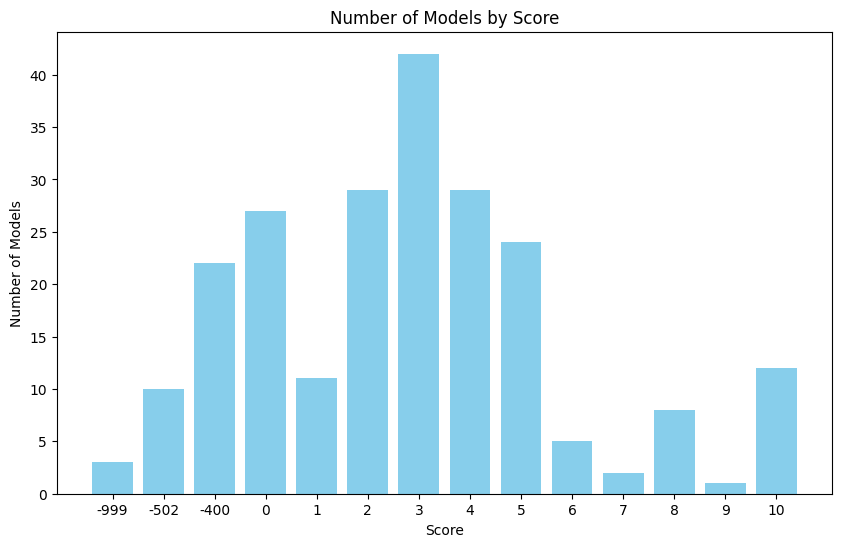

In [13]:
# Graph the results with categorical x-axis for scores
scores_sorted = sorted(score_counts.keys(), key=lambda x: (isinstance(x, int), x))
counts_sorted = [score_counts[s] for s in scores_sorted]
plt.figure(figsize=(10,6))
plt.bar(range(len(scores_sorted)), counts_sorted, color='skyblue')
plt.xlabel('Score')
plt.ylabel('Number of Models')
plt.title('Number of Models by Score')
plt.xticks(range(len(scores_sorted)), [str(s) for s in scores_sorted])
plt.show()

In [14]:
# List models by score
score_to_models = {}
for entry in model_scores:
    score_to_models.setdefault(entry['score'], []).append(entry['model'])
 
for score in sorted(score_to_models):
    print(f"\nModels with score {score}:")
    for model in score_to_models[score]:
        print(f"  {model}")


Models with score -999:
  google/gemini-2.5-flash
  google/gemini-2.5-pro
  google/gemini-2.5-pro-preview-05-06

Models with score -502:
  agentica-org/deepcoder-14b-preview
  arliai/qwq-32b-arliai-rpr-v1
  cognitivecomputations/dolphin3.0-r1-mistral-24b
  google/gemma-3-27b-it
  moonshotai/kimi-vl-a3b-thinking
  nousresearch/deephermes-3-mistral-24b-preview
  opengvlab/internvl3-14b
  perplexity/r1-1776
  shisa-ai/shisa-v2-llama3.3-70b
  thudm/glm-z1-32b

Models with score -400:
  ai21/jamba-1.6-large
  martian/code
  ai21/jamba-1.6-mini
  arcee-ai/arcee-blitz
  arcee-ai/caller-large
  deepseek/deepseek-r1-distill-qwen-1.5b
  deepseek/deepseek-r1-distill-qwen-7b
  eva-unit-01/eva-qwen-2.5-72b
  liquid/lfm-40b
  mistralai/mistral-7b-instruct-v0.2
  morph/morph-v2
  nothingiisreal/mn-celeste-12b
  nousresearch/nous-hermes-2-mixtral-8x7b-dpo
  openai/o1-preview
  openai/o1-preview-2024-09-12
  qwen/qwen-2-72b-instruct
  qwen/qwen3-235b-a22b-07-25
  sao10k/fimbulvetr-11b-v2
  sarvamai/sa

In [17]:
# Re-run models that scored 0 on test[0] and show their outputs
zero_score_models = [m['model'] for m in model_scores if m['score'] == 0]
print(f"Re-running {len(zero_score_models)} models that scored 0 on the first test...")
outputs = []
for model_name in zero_score_models:
    try:
        answer, success = run_model_inference(model_name, tests[0][0], tests[0][1])
    except Exception as e:
        answer = f"Error: {str(e)}"
        success = False
    outputs.append({'model': model_name, 'output': answer, 'success': success})
    print(f"Model: {model_name}\nOutput: {answer}\nSuccess: {success}\n{'-'*40}")

Re-running 27 models that scored 0 on the first test...
Model: alfredpros/codellama-7b-instruct-solidity
Output: $
Success: []
----------------------------------------
Model: alfredpros/codellama-7b-instruct-solidity
Output: $
Success: []
----------------------------------------
Model: deepseek/deepseek-r1-0528
Output: 
Success: []
----------------------------------------
Model: deepseek/deepseek-r1-0528
Output: 
Success: []
----------------------------------------
Model: deepseek/deepseek-r1-distill-llama-70b
Output: 
Success: []
----------------------------------------
Model: deepseek/deepseek-r1-distill-llama-70b
Output: 
Success: []
----------------------------------------
Model: deepseek/deepseek-r1-0528-qwen3-8b
Output: 
Success: []
----------------------------------------
Model: deepseek/deepseek-r1-0528-qwen3-8b
Output: 
Success: []
----------------------------------------
Model: deepseek/deepseek-r1-distill-qwen-14b
Output: **Solution:**

To calculate \(4 + 9\), follow these s